<a href="https://colab.research.google.com/github/subhaz18/colab/blob/main/nlpresumeanalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#spacy
import spacy
from spacy.pipeline import EntityRuler
from spacy.lang.en import English
from spacy.tokens import Doc

#gensim
import gensim
from gensim import corpora
!pip install pyLDAvis
#Visualization
from spacy import displacy
import pyLDAvis.gensim_models
from wordcloud import WordCloud
import plotly.express as px
import matplotlib.pyplot as plt
!pip install jsonlines
#Data loading/ Data manipulation
import pandas as pd
import numpy as np
import jsonlines

#nltk
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download(['stopwords','wordnet'])

#warning
import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 24.2 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [5]:
import csv
df = pd.read_csv("/content/Resume.csv")
df = df.reindex(np.random.permutation(df.index))
data = df.copy().iloc[0:200]
data.head()


,ID,Resume_str,Resume_html,Category
242,25959103,ADMINISTRATOR OF INFORMATION TECHNOLO...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY
440,35474904,ADVOCATE Summary In-depth kn...,"<div class=""fontsize fontface vmargins hmargin...",ADVOCATE
37,21265194,HR PARTNER Summary Expe...,"<div class=""fontsize fontface vmargins hmargin...",HR
170,22675694,GRAPHIC DESIGNER Personal I...,"<div class=""fontsize fontface vmargins hmargin...",DESIGNER
268,28697203,AS INFORMATION TECHNOLOGY PROJ...,"<div class=""RNA skn-mng3 fontsize fontface vma...",INFORMATION-TECHNOLOGY


In [6]:
!python -m spacy info


============================== Info about spaCy ==============================

spaCy version    3.7.5                         
Location         /usr/local/lib/python3.10/dist-packages/spacy
Platform         Linux-6.1.85+-x86_64-with-glibc2.35
Python version   3.10.12                       
Pipelines        en_core_web_sm (3.7.1)        



In [7]:
!python -m spacy --help en_core_web_lg

                                                                                                    
 Usage: python -m spacy [OPTIONS] COMMAND [ARGS]...                                                 
                                                                                                    
 spaCy Command-line Interface                                                                       
 DOCS: https://spacy.io/api/cli                                                                     
                                                                                                    
╭─ Options ────────────────────────────────────────────────────────────────────────────────────────╮
│ --install-completion          Install completion for the current shell.                          │
│ --show-completion             Show completion for the current shell, to copy it or customize the │
│                               installation.                                              

In [8]:
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 1.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [9]:


nlp = spacy.load("en_core_web_lg")
skill_pattern_path = "/content/jz_skill_patterns.jsonl"

In [10]:
ruler = nlp.add_pipe("entity_ruler")
ruler.from_disk(skill_pattern_path)
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'entity_ruler']

In [11]:
def get_skills(text):
    doc = nlp(text)
    myset = []
    subset = []
    for ent in doc.ents:
        if ent.label_ == "SKILL":
            subset.append(ent.text)
    myset.append(subset)
    return subset


def unique_skills(x):
    return list(set(x))

In [12]:
clean = []
for i in range(data.shape[0]):
    review = re.sub(
        '(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?"',
        " ",
        data["Resume_str"].iloc[i],
    )
    review = review.lower()
    review = review.split()
    lm = WordNetLemmatizer()
    review = [
        lm.lemmatize(word)
        for word in review
        if not word in set(stopwords.words("english"))
    ]
    review = " ".join(review)
    clean.append(review)

In [13]:
data["Clean_Resume"] = clean
data["skills"] = data["Clean_Resume"].str.lower().apply(get_skills)
data["skills"] = data["skills"].apply(unique_skills)
data.head()


,ID,Resume_str,Resume_html,Category,Clean_Resume,skills
242,25959103,ADMINISTRATOR OF INFORMATION TECHNOLO...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY,administrator information technology summary a...,"[swift, software, testing, network security, m..."
440,35474904,ADVOCATE Summary In-depth kn...,"<div class=""fontsize fontface vmargins hmargin...",ADVOCATE,advocate summary depth knowledge taking order ...,"[business, marketing, business administration,..."
37,21265194,HR PARTNER Summary Expe...,"<div class=""fontsize fontface vmargins hmargin...",HR,hr partner summary experienced human resource ...,"[business, support, design, collaboration, pro..."
170,22675694,GRAPHIC DESIGNER Personal I...,"<div class=""fontsize fontface vmargins hmargin...",DESIGNER,graphic designer personal information date bir...,"[graphic design, software, support, design, in..."
268,28697203,AS INFORMATION TECHNOLOGY PROJ...,"<div class=""RNA skn-mng3 fontsize fontface vma...",INFORMATION-TECHNOLOGY,information technology project manager summary...,"[business, supervisory control, release, softw..."


In [14]:
fig = px.histogram(
    data, x="Category", title="Distribution of Jobs Categories"
).update_xaxes(categoryorder="total descending")
fig.show()

In [15]:
Job_cat = data["Category"].unique()
Job_cat = np.append(Job_cat, "ALL")

In [16]:
Job_Category=input()

HR


In [17]:
Total_skills = []
if Job_Category != "ALL":
    fltr = data[data["Category"] == Job_Category]["skills"]
    for x in fltr:
        for i in x:
            Total_skills.append(i)
else:
    fltr = data["skills"]
    for x in fltr:
        for i in x:
            Total_skills.append(i)

fig = px.histogram(
    x=Total_skills,
    labels={"x": "Skills"},
    title=f"{Job_Category} Distribution of Skills",
).update_xaxes(categoryorder="total descending")
fig.show()

Text(0.5, 1.0, 'Most Used Words in HR Resume')

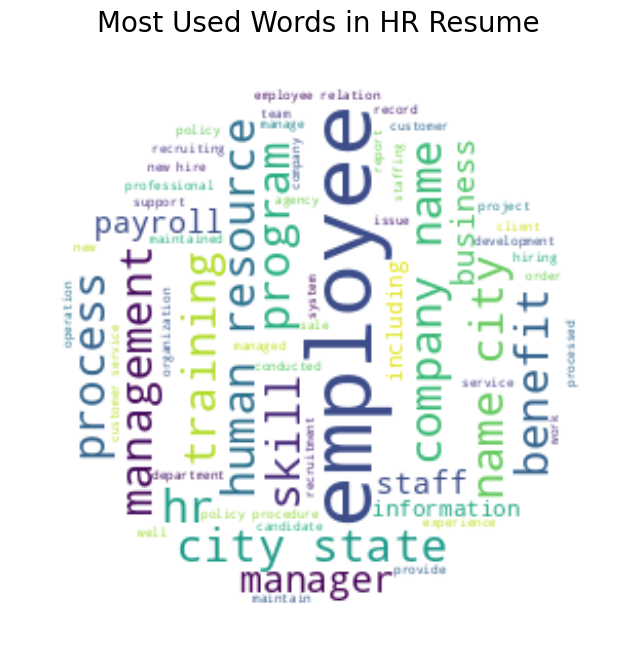

In [18]:
text = ""
for i in data[data["Category"] == Job_Category]["Clean_Resume"].values:
    text += i + " "

plt.figure(figsize=(8, 8))

x, y = np.ogrid[:300, :300]

mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

wc = WordCloud(
    width=800,
    height=800,
    background_color="white",
    min_font_size=6,
    repeat=True,
    mask=mask,
)
wc.generate(text)

plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.title(f"Most Used Words in {Job_Category} Resume", fontsize=20)

In [19]:
sent = nlp(data["Resume_str"].iloc[0])
displacy.render(sent, style="ent", jupyter=True)

In [20]:
displacy.render(sent[0:10], style="dep", jupyter=True, options={"distance": 90})

In [21]:
patterns = df.Category.unique()
for a in patterns:
    ruler.add_patterns([{"label": "Job-Category", "pattern": a}])

In [22]:
# options=[{"ents": "Job-Category", "colors": "#ff3232"},{"ents": "SKILL", "colors": "#56c426"}]
colors = {
    "Job-Category": "linear-gradient(90deg, #aa9cfc, #fc9ce7)",
    "SKILL": "linear-gradient(90deg, #9BE15D, #00E3AE)",
    "ORG": "#ffd966",
    "PERSON": "#e06666",
    "GPE": "#9fc5e8",
    "DATE": "#c27ba0",
    "ORDINAL": "#674ea7",
    "PRODUCT": "#f9cb9c",
}
options = {
    "ents": [
        "Job-Category",
        "SKILL",
        "ORG",
        "PERSON",
        "GPE",
        "DATE",
        "ORDINAL",
        "PRODUCT",
    ],
    "colors": colors,
}
sent = nlp(data["Resume_str"].iloc[5])
displacy.render(sent, style="ent", jupyter=True, options=options)

In [23]:
!pip install docx2txt
import docx2txt


def extract_text_from_docx(docx_path):
    txt = docx2txt.process(docx_path)
    if txt:
        return txt.replace('\t', '     ')
    return None


if __name__ == '__main__':
    input_resume=extract_text_from_docx('/content/Resume.docx')

  Preparing metadata (setup.py) ... done
  Created wheel for docx2txt: filename=docx2txt-0.8-py3-none-any.whl size=3960 sha256=fabb904f6ba01bee64d6bca3036956505a40dbba77960d5051319f26cb396d09
  Stored in directory: /root/.cache/pip/wheels/22/58/cf/093d0a6c3ecfdfc5f6ddd5524043b88e59a9a199cb02352966
Successfully built docx2txt


In [24]:
edu = r'\b([A-Z][^\s,.]+[.]?\s[(]?)([A-Z][^\s,.]+[.]?\s[(]?)*(College|University|Institute|School|School of|Academy)[^,\d]*(?=,|\d)\b'
ee = re.findall(edu, input_resume)
#print(ee)
ed=list()
for i in ee:
  k=""
  for j in i:
    k+=j
  ed.append(k)
print("Education:",ed)


Education: ['Rajalakshmi Engineering College', 'KRM Public School']


In [25]:
cg= r'\bCGPA-*[0-9].*[0-9]*[0-9]\b'
dd = re.findall(cg, input_resume)
print(dd)

['CGPA-8.2']


In [26]:
import re

def extract_name(text):
    # Regular expression pattern for matching names
    name_pattern = re.compile(r'\b[A-Z][a-z]*\s[A-Z][a-z]*\b')

    # Find all potential names in the text
    potential_names = name_pattern.findall(text)

    # Return the first potential name found
    if potential_names:
        return potential_names[0]
    else:
        return None

# Example resume text
resume_text = input_resume

# Extracting name from resume
name = extract_name(resume_text)
print("Applicant's Name:", name)


Applicant's Name: Subhash P


In [27]:
sent2 = nlp(input_resume)
displacy.render(sent2, style="ent", jupyter=True, options=options)

In [28]:
import nltk
nltk.download('punkt')
SKILLS_DB =["python", "java", "machine learning", "data analysis", "natural language processing", "computer vision","sql",'C',"C++","Excel"]
stop_words = set(nltk.corpus.stopwords.words('english'))
word_tokens = nltk.tokenize.word_tokenize(input_resume)

    # remove the stop words
filtered_tokens = [w for w in word_tokens if w not in stop_words]

    # remove the punctuation
filtered_tokens = [w for w in word_tokens if w.isalpha()]

    # generate bigrams and trigrams (such as artificial intelligence)
bigrams_trigrams = list(map(' '.join, nltk.everygrams(filtered_tokens, 2, 3)))

    # we create a set to keep the results in.
found_skills = set()

    # we search for each token in our skills database
for token in filtered_tokens:
  if token.lower() in SKILLS_DB:
    found_skills.add(token)

    # we search for each bigram and trigram in our skills database
for ngram in bigrams_trigrams:
  if ngram.lower() in SKILLS_DB:
    found_skills.add(ngram)
print(list(found_skills))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


['SQL', 'Python', 'Machine Learning']


In [29]:
email_regex = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
emails = re.findall(email_regex, input_resume)
print("Email:",emails)

Email: ['psubhash2004@gmail.com']


In [30]:
phone_regex = r'[\+\(]?[1-9][0-9 .\-\(\)]{8,}[0-9]'
phone_numbers = re.findall(phone_regex, input_resume)
ph=''
#print(type(phone_numbers))
for i in range(len(phone_numbers)):
  for j in phone_numbers[i]:
    if str(j).isdigit():
      ph+=str(j)

#print(phone_numbers)
print("Contact:",ph[2:])
phone=ph[2:]

Contact: 9841633259


In [31]:
input_skills=input()

python


In [32]:
req_skills = input_skills.lower().split(",")
print(req_skills)
resume_skills = unique_skills(get_skills(input_resume.lower()))
score = 0
for x in req_skills:
    if x in resume_skills:
        score += 1
req_skills_len = len(req_skills)
match = round(score / req_skills_len * 100, 1)

print(f"The current Resume is {match}% matched to your requirements")

['python']
The current Resume is 100.0% matched to your requirements


In [33]:
print(resume_skills)

['engineering', 'languages', 'javascript', 'github', 'commerce', 'machine learning', 'ai', 'reinforcement learning', 'python', 'algorithms']


In [34]:
skillss=resume_skills+list(found_skills)
out = map(lambda x:x.lower(),skillss)
print("Skills:",set(out))

Skills: {'engineering', 'languages', 'sql', 'javascript', 'github', 'commerce', 'machine learning', 'ai', 'reinforcement learning', 'python', 'algorithms'}


In [35]:
docs = data["Clean_Resume"].values
dictionary = corpora.Dictionary(d.split() for d in docs)
bow = [dictionary.doc2bow(d.split()) for d in docs]
lda = gensim.models.ldamodel.LdaModel
num_topics = 4
ldamodel = lda(
    bow,
    num_topics=num_topics,
    id2word=dictionary,
    passes=50,
    minimum_probability=0
)
ldamodel.print_topics(num_topics=num_topics)

[(0,
  '0.027*"student" + 0.016*"teacher" + 0.013*"child" + 0.011*"education" + 0.011*"state" + 0.010*"city" + 0.009*"learning" + 0.008*"parent" + 0.007*"classroom" + 0.007*"school"'),
 (1,
  '0.015*"design" + 0.009*"city" + 0.008*"state" + 0.007*"company" + 0.007*"designer" + 0.007*"project" + 0.007*"art" + 0.006*"name" + 0.006*"graphic" + 0.005*"experience"'),
 (2,
  '0.012*"state" + 0.012*"customer" + 0.011*"company" + 0.011*"city" + 0.009*"management" + 0.009*"sale" + 0.008*"service" + 0.008*"business" + 0.008*"name" + 0.007*"employee"'),
 (3,
  '0.020*"system" + 0.011*"server" + 0.010*"technology" + 0.009*"network" + 0.009*"management" + 0.009*"information" + 0.008*"support" + 0.007*"software" + 0.007*"security" + 0.006*"company"')]

In [36]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(ldamodel, bow, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.015430 -0.045690       1        1  53.817370
3     -0.126914 -0.058092       2        1  16.945325
0      0.166103 -0.029558       3        1  15.068672
1     -0.023759  0.133340       4        1  14.168632, topic_info=             Term        Freq       Total Category  logprob  loglift
916       student  515.000000  515.000000  Default  30.0000  30.0000
227        system  625.000000  625.000000  Default  29.0000  29.0000
1208      teacher  284.000000  284.000000  Default  28.0000  28.0000
631        design  330.000000  330.000000  Default  27.0000  27.0000
613         child  257.000000  257.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
12           2013   37.582674  164.132701   Topic4  -6.1077   0.4800
75    development   41.533414  505.419322   Topic4  -6.0077  -0.5448
342          data   38.899786  263.527887   Topic4  -6.0732   0.0410
152           new   40.246168  489.534579   Topic4  -6.0392  -0.5443
144        member   37.533944  246.292992   Topic4  -6.1090   0.0729

[317 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
1095      1  0.164084     0
1095      2  0.378655     0
1095      3  0.012622     0
1095      4  0.441764     0
12        1  0.584893  2013
...     ...       ...   ...
3947      4  0.925923    wy
254       1  0.470564  year
254       2  0.151695  year
254       3  0.210515  year
254       4  0.167174  year

[587 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 1, 2])

In [40]:
import re
edu = r'\b([A-Z][^\s,.]+[.]?\s[(]?)([A-Z][^\s,.]+[.]?\s[(]?)*(College|University|Institute|School|School of|Academy)[^,\d]*(?=,|\d)\b'
ee = re.findall(edu, input_resume)
#print(ee)
e=list()
for i in ee:
  k=""
  for j in i:
    k+=j
  e.append(k)
cg= r'\bCGPA-*[0-9].*[0-9]*[0-9]\b'
d = re.findall(cg, input_resume)

def extract_name(text):
    # Regular expression pattern for matching names
    name_pattern = re.compile(r'\b[A-Z][a-z]*\s[A-Z][a-z]*\b')

    # Find all potential names in the text
    potential_names = name_pattern.findall(text)

    # Return the first potential name found
    if potential_names:
        return potential_names[0]
    else:
        return None

# Example resume text
resume_text = input_resume

# Extracting name from resume
name = extract_name(resume_text)




email_regex = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
emails = re.findall(email_regex, input_resume)






phone_regex = r'[\+\(]?[1-9][0-9 .\-\(\)]{8,}[0-9]'
phone_numbers = re.findall(phone_regex, input_resume)
ph=''
#print(type(phone_numbers))
for i in range(len(phone_numbers)):
  for j in phone_numbers[i]:
    if str(j).isdigit():
      ph+=str(j)

#print(phone_numbers)
print(ph[2:])
phone=ph[2:]



skillss=resume_skills+list(found_skills)
out = map(lambda x:x.lower(),skillss)
#print("Skills:",set(out))









print("EDUCATION:",e)
print("CGPA:",d)
print("Applicant's Name:", name)
print("Email:",emails)
print("Contact:",phone)
print("Skills:",set(out))

9841633259
EDUCATION: ['Rajalakshmi Engineering College', 'KRM Public School']
CGPA: ['CGPA-8.2']
Applicant's Name: Subhash P
Email: ['psubhash2004@gmail.com']
Contact: 9841633259
Skills: {'engineering', 'languages', 'sql', 'javascript', 'github', 'commerce', 'machine learning', 'ai', 'reinforcement learning', 'python', 'algorithms'}
